### Full Name : ahmadreza majlesara
### Student Number : 400101861


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [3]:
def explore_data(data_loader):
    # Get a batch of data
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Plot sample images
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    for i in range(10):
        ax = axes[i]
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

    # Plot label distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(labels.numpy(), bins=np.arange(11) - 0.5, kde=True, edgecolor='black')
    plt.xticks(range(10))
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.title('Label Distribution')
    plt.show()

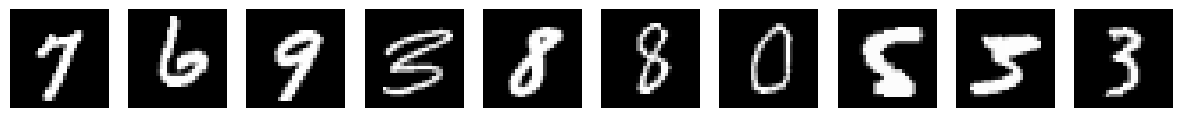

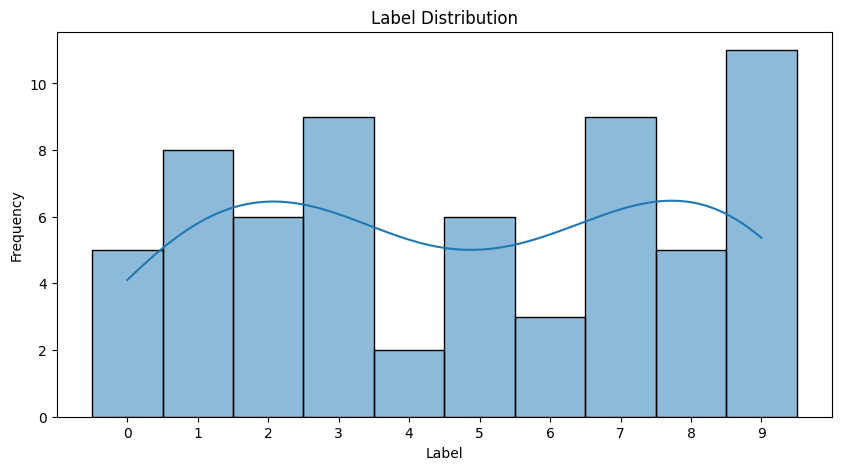

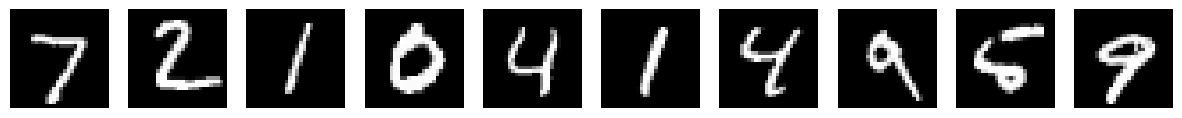

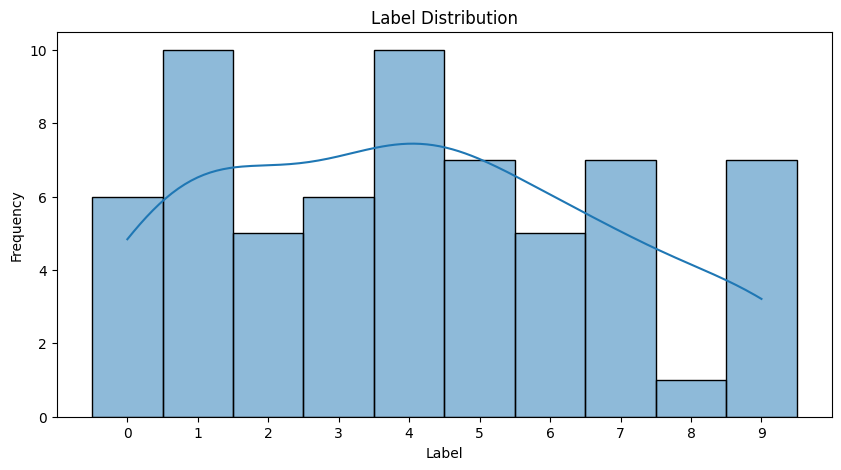

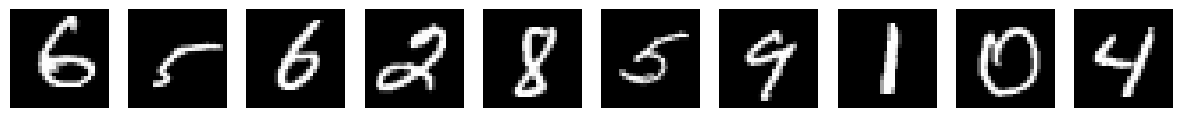

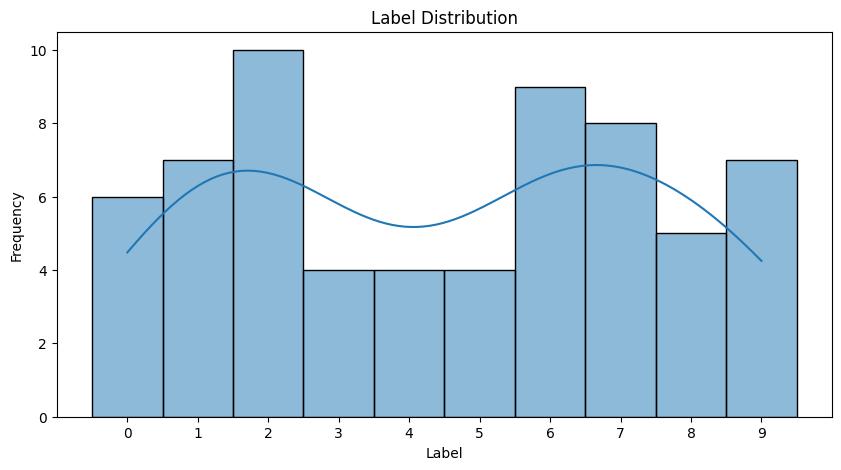

In [4]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader)
explore_data(test_loader)
explore_data(val_loader)


Prepare the data for use with the CART algorithm by flattening the images.

In [5]:
def prepare_data_for_cart(data_loader):
    flattened_images = []
    labels = []

    for images, lbls in data_loader:
        flattened_images.extend(images.view(images.size(0), -1).numpy())
        labels.extend(lbls.numpy())

    flattened_images = np.array(flattened_images)
    labels = np.array(labels)

    return flattened_images, labels

In [6]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

In [7]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(48000, 784) (48000,)
(12000, 784) (12000,)
(10000, 784) (10000,)


## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

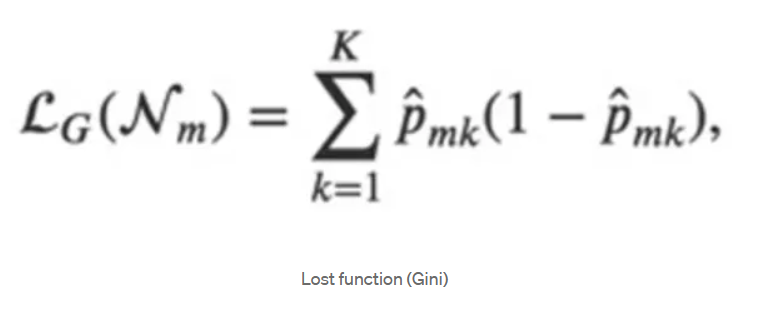

In [8]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        """Public method to train the decision tree."""
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        """Recursive method to grow the decision tree."""
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        if depth >= self.max_depth or num_samples < self.min_samples_split or num_classes == 1:
            return Node(value=self._most_common_label(y))

        best_split = self._best_split(X, y)
        if best_split is None:
            return Node(value=self._most_common_label(y))

        left_indices, right_indices = self._split(X[:, best_split['feature']], best_split['threshold'])
        left_child = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._grow_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature=best_split['feature'], threshold=best_split['threshold'], left=left_child, right=right_child)

    def _best_split(self, X, y):
        """Find the best split point for the dataset."""
        num_samples, num_features = X.shape
        best_gini = float('inf')
        best_split = None

        for feature in range(num_features):
            feature_values = X[:, feature]
            thresholds = np.unique(feature_values)

            for threshold in thresholds:
                left_indices, right_indices = self._split(feature_values, threshold)
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                gini_score = self._weighted_gini(y[left_indices], y[right_indices])
                if gini_score < best_gini:
                    best_gini = gini_score
                    best_split = {'feature': feature, 'threshold': threshold}

        return best_split

    def _split(self, feature_values, threshold):
        """Split the dataset based on the given threshold."""
        left_indices = feature_values < threshold
        right_indices = feature_values >= threshold
        return left_indices, right_indices

    def _weighted_gini(self, y_left, y_right):
        """Calculate the weighted Gini impurity for the left and right branches."""
        m = len(y_left) + len(y_right)
        gini_left = self._gini_impurity(y_left)
        gini_right = self._gini_impurity(y_right)
        weighted_gini = (len(y_left) / m) * gini_left + (len(y_right) / m) * gini_right
        return weighted_gini

    def _gini_impurity(self, y):
        """Calculate Gini impurity for a dataset."""
        m = len(y)
        if m == 0:
            return 0
        class_probs = np.bincount(y) / m
        gini = 1 - np.sum(class_probs ** 2)
        return gini

    def _most_common_label(self, y):
        """Return the most common label in the dataset."""
        return np.bincount(y).argmax()

    def predict(self, X):
        """Predict the label for a given dataset."""
        return np.array([self._traverse_tree(sample, self.root) for sample in X])

    def _traverse_tree(self, sample, node):
        """Traverse the tree recursively to predict a single sample."""
        if node.value is not None:
            return node.value

        if sample[node.feature] < node.threshold:
            return self._traverse_tree(sample, node.left)
        else:
            return self._traverse_tree(sample, node.right)


## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

In [37]:
tree = DecisionTree_CART(max_depth=5)
tree.fit(X_train, y_train)

In [38]:
predictions = tree.predict(X_test)
custom_cart_accuracy = accuracy_score(y_test, predictions)
print(f"Custom CART Accuracy: {custom_cart_accuracy}")

sklearn_tree = DecisionTreeClassifier(max_depth=5)
sklearn_tree.fit(X_train, y_train)
sklearn_predictions = sklearn_tree.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
print(f"Scikit-learn DecisionTreeClassifier Accuracy: {sklearn_accuracy}")


Custom CART Accuracy: 0.6795
Scikit-learn DecisionTreeClassifier Accuracy: 0.6796


1
2
3
4
5
6
7
8
9


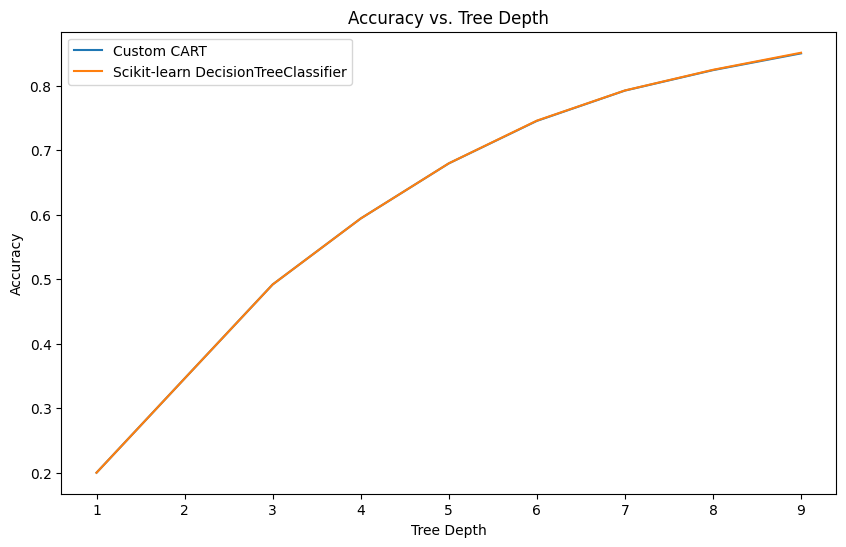

In [45]:
depths = range(1, 10)
custom_cart_accuracies = []
sklearn_accuracies = []

for depth in depths:
    print(depth)
    tree = DecisionTree_CART(max_depth=depth)
    tree.fit(X_train, y_train)
    predictions = tree.predict(X_test)
    custom_cart_accuracies.append(accuracy_score(y_test, predictions))

    sklearn_tree = DecisionTreeClassifier(max_depth=depth)
    sklearn_tree.fit(X_train, y_train)
    sklearn_predictions = sklearn_tree.predict(X_test)
    sklearn_accuracies.append(accuracy_score(y_test, sklearn_predictions))

plt.figure(figsize=(10, 6))
plt.plot(depths, custom_cart_accuracies, label='Custom CART')
plt.plot(depths, sklearn_accuracies, label='Scikit-learn DecisionTreeClassifier')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Tree Depth')
plt.legend()
plt.show()

[0.2, 0.346, 0.4918, 0.5941, 0.6795, 0.7454, 0.7924, 0.8241, 0.8501]
[0.2, 0.346, 0.4918, 0.5941, 0.6796, 0.7458, 0.7926, 0.8246, 0.8511]


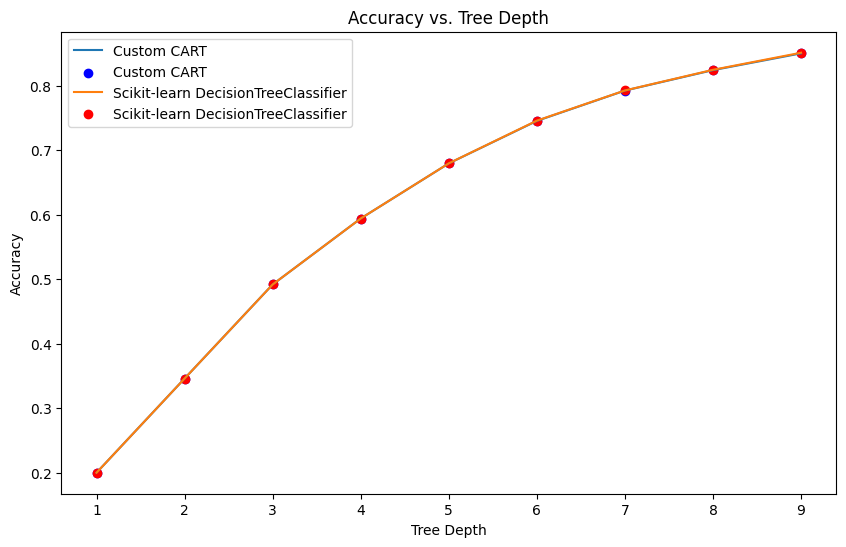

In [47]:
print(custom_cart_accuracies)
print(sklearn_accuracies)
plt.figure(figsize=(10, 6))
plt.plot(depths, custom_cart_accuracies, label='Custom CART')
plt.scatter(depths, custom_cart_accuracies, color='blue', label='Custom CART')
plt.plot(depths, sklearn_accuracies, label='Scikit-learn DecisionTreeClassifier')
plt.scatter(depths, sklearn_accuracies, color='red', label='Scikit-learn DecisionTreeClassifier')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Tree Depth')
plt.legend()
plt.show()

In [11]:
tree10 = DecisionTree_CART(max_depth=10)
tree10.fit(X_train, y_train)

predictions10 = tree10.predict(X_test)
custom_cart_accuracy10 = accuracy_score(y_test, predictions10)
print(f"Custom CART Accuracy (Depth=10): {custom_cart_accuracy10}")

sklearn_tree10 = DecisionTreeClassifier(max_depth=10)
sklearn_tree10.fit(X_train, y_train)
sklearn_predictions10 = sklearn_tree10.predict(X_test)
sklearn_accuracy10 = accuracy_score(y_test, sklearn_predictions10)
print(f"Scikit-learn DecisionTreeClassifier Accuracy (Depth=10): {sklearn_accuracy10}")

conf_matrix_custom = confusion_matrix(y_test, predictions10)
print("Confusion Matrix for Custom CART (Depth=10):")
print(conf_matrix_custom)

conf_matrix_sklearn = confusion_matrix(y_test, sklearn_predictions10)
print("Confusion Matrix for Scikit-learn DecisionTreeClassifier (Depth=10):")
print(conf_matrix_sklearn)


Custom CART Accuracy (Depth=10): 0.8579
Scikit-learn DecisionTreeClassifier Accuracy (Depth=10): 0.8593
Confusion Matrix for Custom CART (Depth=10):
[[ 925    1   15    3    4   14    6    5    5    2]
 [   0 1094    5    3    5    5    8    1    9    5]
 [  11    6  885   33   24    4   23   12   22   12]
 [  13    2   20  839    5   59    5   15   33   19]
 [   4   10   13    8  808   11   17    6   26   79]
 [  14   11    8   53   12  717   26    5   29   17]
 [  22    4   16    2   31   16  838    4   20    5]
 [   4    9   53   25   11    4    3  883   10   26]
 [  15   18   36   32   15   36   24    8  744   46]
 [   6    3   12   23   44   20   11   20   24  846]]
Confusion Matrix for Scikit-learn DecisionTreeClassifier (Depth=10):
[[ 922    0   16    5    2   13    8    6    5    3]
 [   0 1094    5    4    5    4    9    1    8    5]
 [  10    5  886   34   23    4   22   13   23   12]
 [  10    0   22  841    5   61    5   14   35   17]
 [   6    9   13    7  809   10   15   

## Question
What is the difference between ID3 and CART algorithm